In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math

import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from gensim.models.phrases import Phrases, Phraser


import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Reading and exploring the dataset 

In [67]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Text Representation and Classification/IMDB Dataset.csv')

In [68]:
dataset.head(4)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative


In [69]:
dataset.describe

<bound method NDFrame.describe of                                                   review sentiment
0      One of the other reviewers has mentioned that ...  positive
1      A wonderful little production. <br /><br />The...  positive
2      I thought this was a wonderful way to spend ti...  positive
3      Basically there's a family where a little boy ...  negative
4      Petter Mattei's "Love in the Time of Money" is...  positive
...                                                  ...       ...
49995  I thought this movie did a down right good job...  positive
49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
49997  I am a Catholic taught in parochial elementary...  negative
49998  I'm going to have to disagree with the previou...  negative
49999  No one expects the Star Trek movies to be high...  negative

[50000 rows x 2 columns]>

In [70]:
dataset.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

#  Mapping Sentiment

In [71]:
dataset['sentiment'] = dataset['sentiment'].apply(lambda x:1 if x == 'positive' else 0)
dataset['sentiment']

0        1
1        1
2        1
3        0
4        1
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: sentiment, Length: 50000, dtype: int64

# Defining helpers functions for cleaning text

In [72]:
sw = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    
    text = text.lower()

    html=re.compile('<.*?>') 
    
    text = re.sub(html,'',text) #Removing html tags
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    text = re.sub(r"http", "",text)
    
    
    
    punctuations = '@#!?+&*[]-%.,:/();$=><|{}^' + "'`" + '_' 
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [73]:
dataset['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [74]:
dataset['review'] = dataset['review'].apply(lambda x: clean_text(x))
 
dataset['review'][1]

'wonderful little production filming technique unassuming old time bbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwell mural decorating every surface terribly well done'

In [76]:
X_train, X_test, y_train, y_test = train_test_split(dataset['review'], dataset['sentiment'], test_size = .4, shuffle = False)

In [77]:
len(X_train), len(y_train), len(X_test), len(y_test)

(30000, 30000, 20000, 20000)

# Defining helpers functions for text representation

## Fast text vectors reprensentation

In [78]:
from gensim.models import FastText

In [79]:
from gensim.models import FastText
sent_list = [row.split() for row in dataset['review']]
phrases = Phrases(sent_list, min_count = 30, progress_per = 10000)
sentences = phrases[sent_list]
model = FastText(vector_size=30, window=4, min_count=1)  # instantiate
model.build_vocab(corpus_iterable=sentences)
model.train(corpus_iterable=sentences, total_examples=len(sentences), epochs=10)  # train
model.wv.get_vector("dog")

array([ 0.9960548 , -3.0300138 , -6.900286  ,  4.6276975 , -2.6512425 ,
       -6.775219  , -1.8265574 , -0.05026779,  3.2416828 , -0.8067989 ,
       -1.7859584 , -4.767736  ,  3.8884056 ,  1.22623   , -2.0160928 ,
       -3.4094734 ,  2.5728967 ,  6.0300875 ,  0.46872118, -4.717366  ,
        4.3411093 , -3.8522267 , -1.4749184 , -2.967053  ,  4.066123  ,
        1.6556491 ,  0.9151018 ,  1.2305063 , -4.650937  , -0.13340583],
      dtype=float32)

In [81]:
from gensim.models import KeyedVectors

In [82]:
print(type(model.wv))
dataset["embedding_fasttext"]=dataset["review"].map(lambda sentence: model.wv.get_mean_vector(sentence) )

dataset["embedding_fasttext"] #will give us the mean vector of each review so you will use it for the classification tast 


<class 'gensim.models.fasttext.FastTextKeyedVectors'>


0        [-0.027420852, 0.16789165, -0.021704976, -0.03...
1        [-0.03638706, 0.16901922, -0.019489158, -0.027...
2        [-0.028730672, 0.17437468, -0.017166546, -0.02...
3        [-0.042970777, 0.1761982, -0.010121323, -0.026...
4        [-0.025147155, 0.15965112, -0.0235565, -0.0211...
                               ...                        
49995    [-0.038188078, 0.17250514, -0.0201566, -0.0189...
49996    [-0.017157992, 0.15423708, -0.018724632, -0.01...
49997    [-0.019056242, 0.16534145, -0.013090759, -0.02...
49998    [-0.0359463, 0.1697255, -0.022891423, -0.02782...
49999    [-0.041548874, 0.17325535, -0.020807544, -0.02...
Name: embedding_fasttext, Length: 50000, dtype: object

In [96]:
text_vect = dataset["embedding_fasttext"]

In [ ]:
text_vect.to_list()

In [99]:
data = pd.DataFrame(text_vect.to_list())

In [100]:
data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.027421,0.167892,-0.021705,-0.034026,0.093655,-0.269062,0.064188,-0.120341,-0.128271,0.034849,...,0.121891,0.055871,-0.092140,-0.042272,-0.038283,0.064822,0.017909,-0.140224,-0.090288,0.135369
1,-0.036387,0.169019,-0.019489,-0.027335,0.099835,-0.267050,0.068829,-0.136708,-0.135185,0.048365,...,0.136070,0.052110,-0.093355,-0.037905,-0.053179,0.069655,0.015360,-0.134275,-0.086252,0.144290


In [101]:
Fast_X_train, Fast_X_test, Fast_y_train, Fast_y_test = train_test_split(data, dataset['sentiment'], test_size = .4, shuffle = False)

In [102]:
Fast_X_train

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.027421,0.167892,-0.021705,-0.034026,0.093655,-0.269062,0.064188,-0.120341,-0.128271,0.034849,...,0.121891,0.055871,-0.092140,-0.042272,-0.038283,0.064822,0.017909,-0.140224,-0.090288,0.135369
1,-0.036387,0.169019,-0.019489,-0.027335,0.099835,-0.267050,0.068829,-0.136708,-0.135185,0.048365,...,0.136070,0.052110,-0.093355,-0.037905,-0.053179,0.069655,0.015360,-0.134275,-0.086252,0.144290
2,-0.028731,0.174375,-0.017167,-0.028950,0.095590,-0.266574,0.061243,-0.120643,-0.130438,0.043009,...,0.122669,0.055821,-0.091104,-0.045563,-0.041858,0.061276,0.019357,-0.146171,-0.086951,0.135387
3,-0.042971,0.176198,-0.010121,-0.026950,0.084486,-0.257575,0.059417,-0.131304,-0.130179,0.025485,...,0.130933,0.062123,-0.093452,-0.043537,-0.045419,0.063018,0.018731,-0.133345,-0.081021,0.135780
4,-0.025147,0.159651,-0.023557,-0.021143,0.093664,-0.268883,0.058996,-0.136659,-0.129862,0.035124,...,0.129613,0.064949,-0.099095,-0.037453,-0.048625,0.078005,0.021057,-0.134767,-0.088892,0.142422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-0.025428,0.163249,-0.021673,-0.022353,0.097883,-0.269333,0.070050,-0.128711,-0.130638,0.037225,...,0.127036,0.059735,-0.092024,-0.040106,-0.047637,0.069882,0.016481,-0.141978,-0.097893,0.142784
29996,-0.045718,0.188379,0.002289,-0.036224,0.089042,-0.250712,0.049760,-0.134502,-0.123648,0.020307,...,0.115943,0.060268,-0.105534,-0.062952,-0.042614,0.068265,0.021842,-0.130761,-0.050276,0.129357
29997,-0.032779,0.176013,-0.013712,-0.038399,0.085702,-0.254604,0.069978,-0.122719,-0.121330,0.023950,...,0.104600,0.058078,-0.090690,-0.036067,-0.036478,0.065618,0.010716,-0.124675,-0.076792,0.123832
29998,-0.024884,0.151767,-0.024801,-0.016224,0.086929,-0.265632,0.063731,-0.123496,-0.126897,0.034873,...,0.127344,0.061543,-0.086203,-0.026528,-0.043777,0.066379,0.021318,-0.135630,-0.096524,0.140165


## TF-IDF Representation

In [ ]:
def find_vocabulary(corpus):
  """
    This method is used to find the vocabulary of our corpus
  """
  #print(corpus)
  list_of_word = []
  for i in range(len(corpus)):
    #print(len(corpus))
    list_of_word.extend(corpus[i].split())

  vocabulary = list(set(list_of_word))
  return vocabulary

In [ ]:
vocabulary = find_vocabulary(dataset['review'])
 
vocabulary

['liken',
 'allgo',
 'trainingground',
 'juxtaposed',
 'pointblack',
 'populer',
 'havea',
 'ferch',
 'billingham',
 'anisio',
 'springergate',
 'selae',
 'awfulavoid',
 'aboutbeing',
 'moneylysette',
 'washow',
 'taleif',
 'kidnaps',
 'gentelmen',
 'capering',
 'tby',
 'foolhardyso',
 'rapesshanking',
 'screenplaycheers',
 'hilarioushowever',
 'determinate',
 'summerthe',
 'prostrating',
 'kuba',
 'uhf',
 'rivio',
 'goodoverall',
 'checkentertainment',
 'bekhti',
 'purply',
 'mvc',
 'sew',
 'woodenthere',
 'overpowered',
 'alivewe',
 'shaky',
 'qualityellen',
 'shotty',
 'concert',
 'silvestres',
 'holmann',
 'outerlimits',
 'torure',
 'morlochs',
 'marioncarrotthe',
 'ownexcept',
 'tapeat',
 'daftbut',
 'cassetti',
 'earring',
 'yeung',
 'nationally',
 'ad',
 'nainital',
 'casei',
 'afterwardsas',
 'babbling',
 'marais',
 'godamnawful',
 'laughableif',
 'geeeee',
 'reclaiming',
 'amazingand',
 'reily',
 'billyclub',
 'facea',
 'jumbled',
 'correli',
 'troama',
 'joxer',
 'idyll',
 'j

In [ ]:
len(vocabulary)

155536

In [ ]:
def occurence_word(corpus):
  """
    This method is used to compute, for each word in the vocabulary, it number of appearance
  """
  word_counter = { }
  vocabulary = find_vocabulary(corpus)
  for word in vocabulary:
    counter = [ ]
    counter = [corpus[i].split().count(word) for i in range(len(corpus))]

    word_counter[word] = counter

  return word_counter

In [ ]:
def occurence_word_document(corpus):
  """
  This method is used to compute the number of documents containing the word w
  """
  vocabulary = find_vocabulary(corpus)
  doc_counter = { }
  dic = zip(vocabulary, [0]*len(vocabulary))
  doc_counter = dict(dic)

  # compute for each word, the number of time it appears
  for word in doc_counter.keys():
    counter = [1 for i in range(len(corpus)) if word in corpus[i].split()]
    doc_counter[word] = sum(counter)

  return doc_counter

In [ ]:
def compute_IDF(corpus):
  """
  This method is used to compute IDF of each word
  """
  n_documents = len(corpus)
  vocabulary = find_vocabulary(corpus)
  IDF = { }
  
  occ = np.array(list(occurence_word_document(corpus).values()))
  idf1 = np.log10(n_documents/occ)
  dic = zip(vocabulary, idf1)
  IDF = dict(dic)

  return IDF

In [ ]:
def compute_TF(corpus):
  """
  This method compute the TF of each word
  """
  n_documents = len(corpus)
  vocabulary = find_vocabulary(corpus)
  TF = { }

  occ = list(occurence_word(corpus).values())
  for i in range(len(occ)):
    for j in range(n_documents):
   
      occ[i][j] = np.array(occ[i][j])/len(corpus[j].split())
    
  
  dic = zip(vocabulary, np.array(occ))
  TF = dict(dic)

  return TF

In [ ]:
def compute_TF_IDF(corpus):
  """
  This function compute the TF-IDF of each word
  """
  tf_idf = []
  TF = list(compute_TF(corpus).values())
  IDF = list(compute_IDF(corpus).values())
  for i in range(len(TF)):
    tf_idf.append(IDF[i]*TF[i])

  return tf_idf

In [ ]:
dataset = compute_TF_IDF(dataset.review[:10])

In [ ]:
dataset

[array([0.        , 0.        , 0.        , 0.01587302, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01282051, 0.        , 0.        ]),
 array([0.   , 0.   , 0.   , 0.   , 0.008, 0.   , 0.   , 0.   , 0.   ,
        0.   ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.01282051, 0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01612903, 0.        ]),
 array([0.        , 0.01162791, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.01369863, 0.        , 0.        , 0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.      

### TF-IDF using scikit learn

In [ ]:
def tokenize(text):
    return [word for word in word_tokenize(text.lower()) if word not in stopwords.words('english')]

In [ ]:
def choose_vectorizer(option):
    if option == 'generate':
        vectorizer = TfidfVectorizer(tokenizer = tokenize)
    elif option == 'load':
        vectorizer = TfidfVectorizer(vocabulary = pickle.load(open('vocabulary.pkl', 'rb')))
    
    return vectorizer

In [ ]:
%%time
options = ['generate', 'load']

# 0 to generate, 1 to load (choose wisely, your life depends on it!)
option = options[0] 

vectorizer = choose_vectorizer(option)
vectorized_train_data = vectorizer.fit_transform(X_train)
vectorized_test_data = vectorizer.transform(X_test)
    
if option == 'generate':
    pickle.dump(vectorizer.vocabulary_, open('vocabulary.pkl', 'wb'))

CPU times: user 6min 8s, sys: 55.8 s, total: 7min 4s
Wall time: 7min 7s


In [ ]:
# vectorized_train_dataFrame = pd.DataFrame(vectorized_train_data.toarray(), columns = vectorizer.get_feature_names_out())

In [ ]:
# vectorizer.get_feature_names_out()

In [ ]:
# vectorized_train_dataFrame.head(2)

# Implementing Bernoulli Naive Bayes Class

In [103]:
def accuracy(y,y_pred):
    score = np.mean(y==y_pred)
    
    return score*100

In [107]:
class BernoulliNaiveBayes:
    
    def __init__(self, alpha = 1):
        self.alpha = alpha
        return
    
    def fit(self, X, y):
        #X = X.todense()
        # count number of occurrences for each label
        y_counts = np.unique(y, return_counts=True)[1]
        
        self.n_classes = len(np.unique(y))
        self.n_features = X.shape[1]
        
        # calculate P(y), 
        prior_class = y_counts / np.sum(y_counts)
        self.log_prior_class = np.log(prior_class).reshape(-1,1)
        
        # calculate P(x|y), 
        prob_x_given_y = np.zeros([self.n_classes, self.n_features])
        
        # for each class of y
        for i in range(self.n_classes):
            
            # select only rows of class y
            #row_select = (y == i) 
            #X_filtered = X[(y == i), :]
            X_label = X[(y == i)]
            
            # ( P(x and y) )
            numerator = (X_label.sum(axis = 0) + self.alpha)
                        
            # ( P(y) )
            denominator = (X_label.shape[0] + 2 * self.alpha)
            
            # P(x|y) = P(x and y) / P(y)
            prob_x_given_y[i, :] = numerator / denominator
            
            
        # Calculate log probabilities for P(x|y) and P(~x|y)
        self.log_class_conditional_positive = np.log(prob_x_given_y) # k x n matrix
        self.log_class_conditional_negative = np.log(1 - prob_x_given_y) # k x n matrix
            
    def predict(self, X):
        
        #X = X.todense() # m x d matrix
        
        # log P(y|x) is proportional to log P(x|y) + log P(y)
        # each n x 1 column vector is contains a value proportional to P(y|x)
        # for every possible class of y
        log_probs_positive = self.log_class_conditional_positive.dot(X.T) # n x m matrix
        log_probs_negative = self.log_class_conditional_negative.dot(1 - X.T) # n x m matrix        
        log_likelihoods = log_probs_positive + log_probs_negative # n x m matrix
        log_joint_likelihoods = log_likelihoods + self.log_prior_class # n x m matrix
        
        # for each column vector, find class y that maximizes P(y|x)
        preds = np.argmax(log_joint_likelihoods, axis = 0) # 1 x m matrix
        preds = np.array(preds).squeeze() # m-dimensional vector
        return preds

In [ ]:
model_TF_IDF = BernoulliNaiveBayes()
model_TF_IDF.fit(vectorized_train_data, y_train)

y_pred = model_TF_IDF.predict(vectorized_test_data)
accuracy(y_test,y_pred)


86.165

In [ ]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(vectorized_train_data, y_train)
#BernoulliNB(force_alpha=True)
y_pred = clf.predict(vectorized_test_data)
accuracy(y_test,y_pred)

85.165

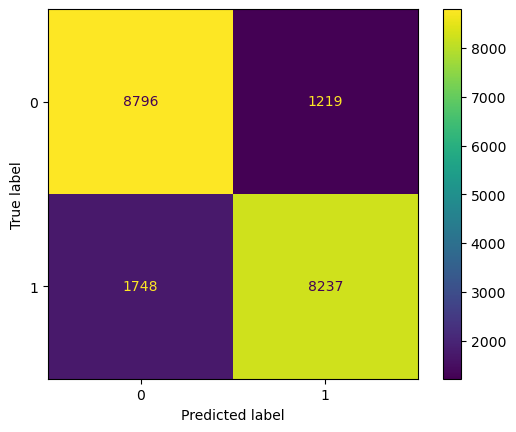

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels = np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot()
plt.show()

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86     10015
           1       0.87      0.82      0.85      9985

    accuracy                           0.85     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.85      0.85      0.85     20000





---



In [108]:
model_Fast_Text = BernoulliNaiveBayes()
model_Fast_Text.fit(Fast_X_train, Fast_y_train.to_numpy())

y_pred = model_Fast_Text.predict(Fast_X_test)
accuracy(Fast_y_test,y_pred)

<ipython-input-107-19e8cda9d4aa>:41: RuntimeWarning: invalid value encountered in log
  self.log_class_conditional_positive = np.log(prob_x_given_y) # k x n matrix


50.075

In [113]:
Fast_y_test.to_numpy().reshape(-1,1)

(20000,)

In [115]:
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(Fast_X_train, Fast_y_train.to_numpy())
#BernoulliNB(force_alpha=True)
y_pred = clf.predict(Fast_X_test)
accuracy(Fast_y_test,y_pred)

52.205

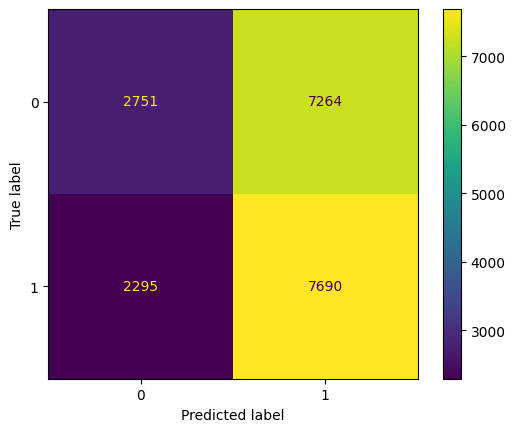

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels = np.unique(y_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

disp.plot()
plt.show()

In [117]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.55      0.27      0.37     10015
           1       0.51      0.77      0.62      9985

    accuracy                           0.52     20000
   macro avg       0.53      0.52      0.49     20000
weighted avg       0.53      0.52      0.49     20000

